<a href="https://colab.research.google.com/github/haiderareeb/DesicionTreesLearning/blob/main/DesicionTreesRainForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#requirements
!pip install pandas-profiling numpy matplotlib seaborn --quiet
!pip install opendatasets scikit-learn  --quiet --upgrade
!pip install plotly --quiet --upgrade
import plotly.express as px
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.9 MB/s eta 0:00:00


In [3]:
# Data Gathering
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
os.listdir('weather-dataset-rattle-package')
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')
raw_df.info()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: areebhaider
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package


100%|██████████| 3.83M/3.83M [00:00<00:00, 195MB/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
# Data Analysis

# plt.title('No. of Rows per Year')
# sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year)

# px.histogram(raw_df,
#                     x='RainTomorrow',
#                     color='RainToday',
#                     title='Rain Tomorrow vs. Rain Today'
#                       ).show()

# fig1 = px.histogram(raw_df,
#              x='RainTomorrow',
#              color='',
#              title='Rain Tomorrow vs. humidity3pm'
#                 )
# fig1.update_layout(width=1000, height=1000).show()



In [4]:
# Data Preprocessing
raw_df.dropna(subset=['RainTomorrow'],inplace=True)


#split dataset
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year<2015]
val_df = raw_df[year==2015]
test_df = raw_df[year>2015]

# print('train_df shape:',train_df.shape)
# print('val_df shape:',val_df.shape)
# print('test_df shape:',test_df.shape)

#Inputs & Targets cols
input_cols = list(train_df.columns[1:-1])
target_col = 'RainTomorrow'

#creating inputs and outputs for each dataset
train_inputs= train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs= val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs= test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

#collect numerical & categorical cols
numerical_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

#Imputing Missing Numeric Values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean').fit(raw_df[numerical_cols])
train_inputs[numerical_cols] = imputer.transform(train_inputs[numerical_cols])
val_inputs[numerical_cols] = imputer.transform(val_inputs[numerical_cols])
test_inputs[numerical_cols] = imputer.transform(test_inputs[numerical_cols])

#check
# test_inputs[numerical_cols].isna().sum()

#Scaling Numeric Features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(raw_df[numerical_cols])
train_inputs[numerical_cols] = scaler.transform(train_inputs[numerical_cols])
val_inputs[numerical_cols] = scaler.transform(val_inputs[numerical_cols])
test_inputs[numerical_cols] = scaler.transform(test_inputs[numerical_cols])

#check
# val_inputs.describe().loc[['min','max']]

#Encoding Categorical data
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoded_train = pd.DataFrame(encoder.transform(train_inputs[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=train_inputs.index)
encoded_val = pd.DataFrame(encoder.transform(val_inputs[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=val_inputs.index)
encoded_test = pd.DataFrame(encoder.transform(test_inputs[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=test_inputs.index)

# Concatenate numeric and one-hot encoded categorical columns into single dataframe
train_inputs = pd.concat([train_inputs[numerical_cols], encoded_train], axis=1)
val_inputs = pd.concat([val_inputs[numerical_cols], encoded_val], axis=1)
test_inputs = pd.concat([test_inputs[numerical_cols], encoded_test], axis=1)

# Save processed data to disk
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

# Load processed data from disk
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')
train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Training Decision Tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(train_inputs,train_targets)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
train_preds = model.predict(train_inputs)
train_probs = model.predict_proba(train_inputs)
# pd.Series(train_preds).value_counts()
# train_probs
accuracy_score(train_targets,train_preds)
model.score(val_inputs,val_targets)

#comparing model score with dumb model
val_targets.value_counts()/len(val_targets) #always predicting No

,count
RainTomorrow,
No,0.788289
Yes,0.211711


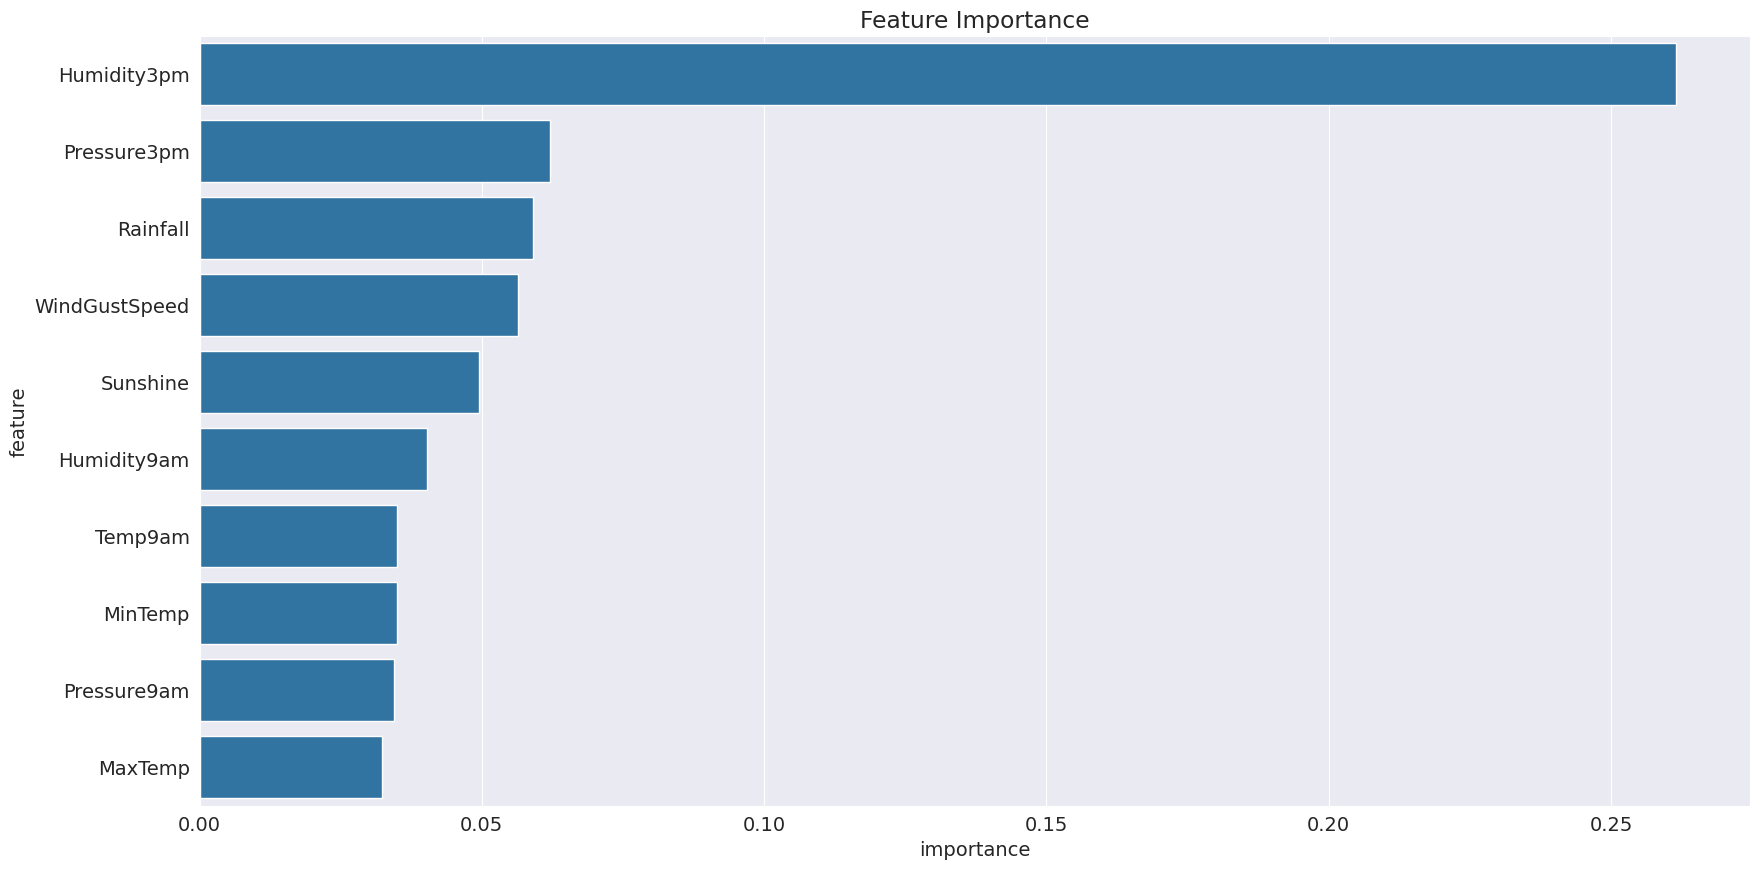

In [ ]:
# Model Visualization & Analysis
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(20,10))
# plot_tree(model,
#           feature_names=train_inputs.columns,
#           max_depth=3, #levels of tree
#           filled=True)
# plt.show

#total no. of levels
model.tree_.max_depth

#display the tree as text
tree_text = export_text(model, max_depth=10, feature_names=list(train_inputs.columns))
# print(tree_text[:5000])

#importances = gini
model.feature_importances_
importance_df = pd.DataFrame({
    'feature':train_inputs.columns,
    'importance':model.feature_importances_}).sort_values('importance',ascending=False)
# importance_df.head(10)

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

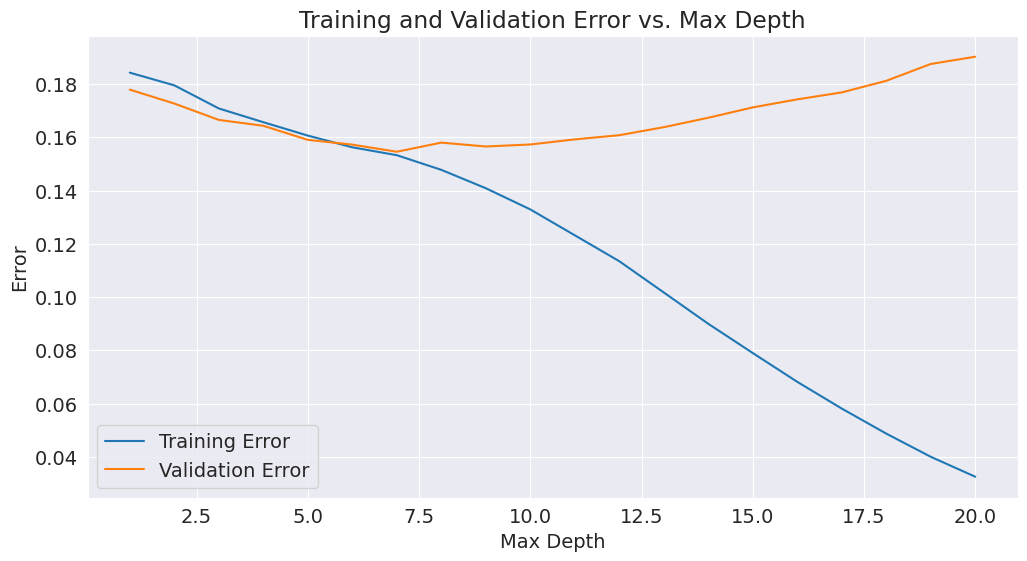

0.8453949277465034

In [ ]:
# Hyperparameter Tuning & Overfitting
#The DecisionTreeClassifier accepts several arguments, some of which can be modified to reduce overfitting.
#These arguments are called hyperparameters because they must be configured manually

# 1) max_depth : By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization
model = DecisionTreeClassifier(random_state=42, max_depth=3)
model.fit(train_inputs,train_targets)
# print("Model Score in Training :",model.score(train_inputs,train_targets))
# print("Model Score in validation : " ,model.score(val_inputs,val_targets))
# model.classes_
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(train_inputs, train_targets)
    train_acc = 1 - model.score(train_inputs, train_targets)
    val_acc = 1 - model.score(val_inputs, val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}
#time to run
# %%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])
# errors_df
plt.figure(figsize=(12, 6))
plt.plot(errors_df['Max Depth'], errors_df['Training Error'], label='Training Error')
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'], label='Validation Error')
plt.xlabel('Max Depth')
plt.ylabel('Error')
plt.title('Training and Validation Error vs. Max Depth')
plt.legend()
plt.show()

model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(train_inputs, train_targets)
model.score(val_inputs, val_targets)


In [ ]:
#Saving and loading the trained models
import joblib
modelMaxDepth7 = {
    'model1': model,
    'imputer1': imputer,
    'encoder1': encoder,
    'scaler1': scaler,
    'input_cols': input_cols,
    'target_col': target_col,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(modelMaxDepth7,'modelMaxDepth7.joblib')
model1 = joblib.load('modelMaxDepth7.joblib')

Model Score in Training : 0.8466884874934335
Model Score in validation :  0.8453949277465034


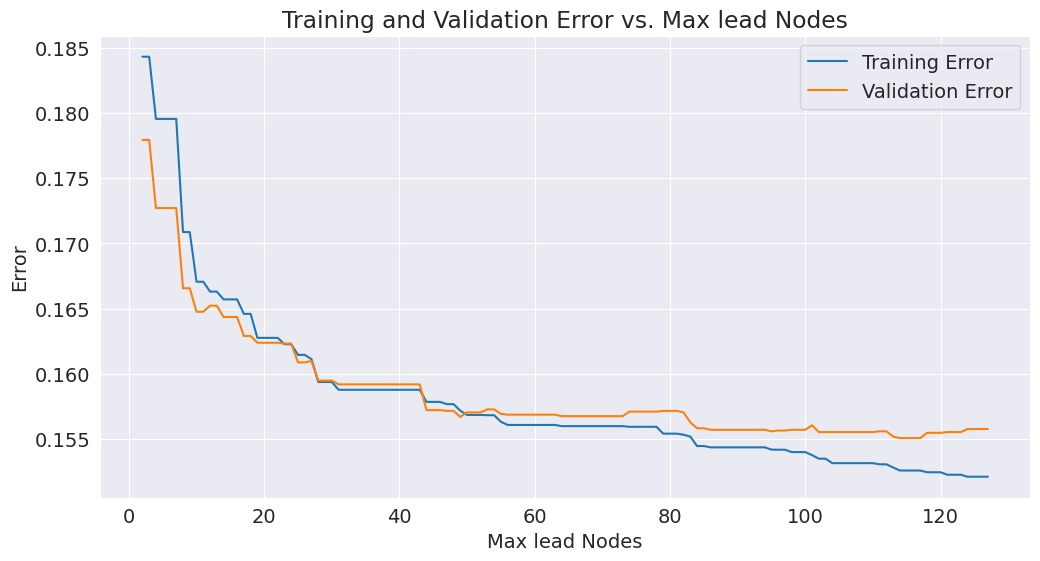

In [ ]:
#2) max_leaf_nodes: Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths.
model2 = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)
model2.fit(train_inputs,train_targets)
print("Model Score in Training :",model.score(train_inputs,train_targets))
print("Model Score in validation : " ,model.score(val_inputs,val_targets))
model2.tree_.max_depth
def max_leaf_nodes_error(mn):
    model2 = DecisionTreeClassifier(max_leaf_nodes=mn, random_state=42)
    model2.fit(train_inputs, train_targets)
    train_acc = 1 - model2.score(train_inputs, train_targets)
    val_acc = 1 - model2.score(val_inputs, val_targets)
    return {'Max lead Nodes': mn, 'Training Error': train_acc, 'Validation Error': val_acc}

errors_df = pd.DataFrame([max_leaf_nodes_error(mn) for mn in range(2,128)])
# errors_df
plt.figure(figsize=(12, 6))
plt.plot(errors_df['Max lead Nodes'], errors_df['Training Error'], label='Training Error')
plt.plot(errors_df['Max lead Nodes'], errors_df['Validation Error'], label='Validation Error')
plt.xlabel('Max lead Nodes')
plt.ylabel('Error')
plt.title('Training and Validation Error vs. Max lead Nodes')
plt.legend()
plt.show()

In [ ]:
#setting max_leaf_nodes to reduce overfitting
model2 = DecisionTreeClassifier(max_leaf_nodes=90,random_state=42)
model2.fit(train_inputs,train_targets)
print("Model Score in Training :",model.score(train_inputs,train_targets))
print("Model Score in validation : " ,model.score(val_inputs,val_targets))

#Saving and loading the trained models
import joblib
modelMax_leaf_nodes = {
    'model': model2,
    'imputer': imputer,
    'encoder': encoder,
    'scaler': scaler,
    'input_cols': input_cols,
    'target_col': target_col,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(modelMax_leaf_nodes,'modelMax_leaf_nodes.joblib')
model2 = joblib.load('modelMax_leaf_nodes.joblib')


Model Score in Training : 0.8466884874934335
Model Score in validation :  0.8453949277465034


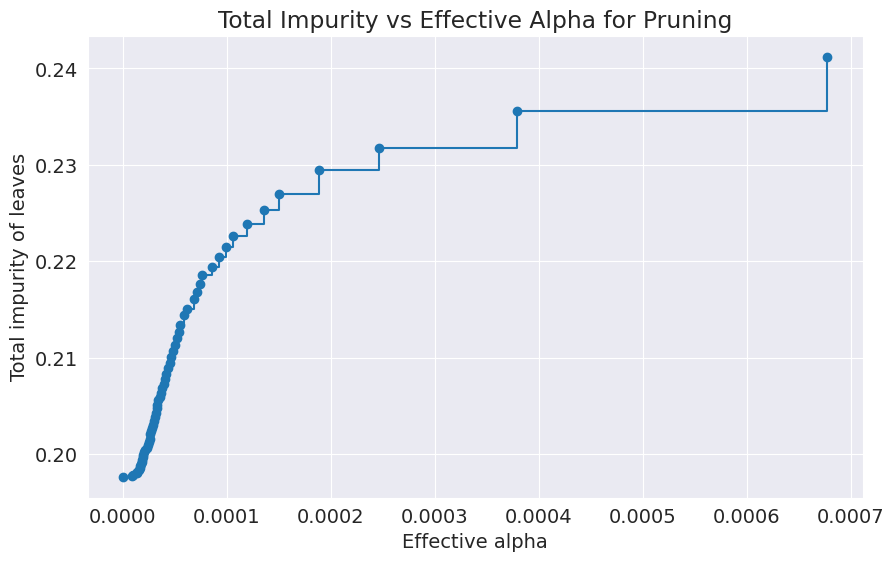

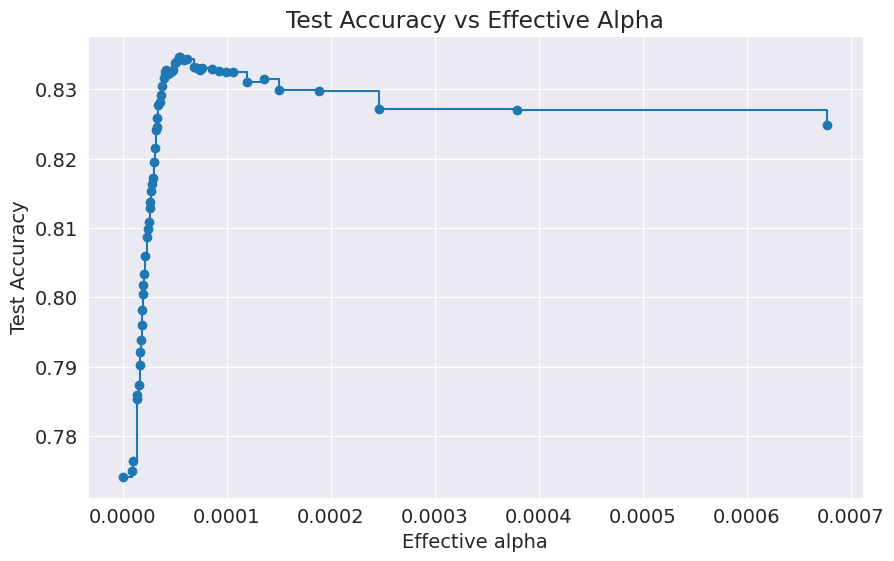

Model Score on Training Data: 0.8594577120459046
Model Score on Validation Data: 0.8441181591317973


In [10]:
# Train a decision tree classifier (without pruning)
#3) cost-complexity pruning
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Train a decision tree classifier (without pruning)
clf = DecisionTreeClassifier(random_state=42, max_depth=10)
clf.fit(train_inputs, train_targets)

# Get cost complexity pruning path
path = clf.cost_complexity_pruning_path(train_inputs, train_targets)
ccp_alphas, impurities = path.ccp_alphas[::10], path.impurities[::10]  # Take every 10th alpha value to reduce computations

# Plot alpha vs impurity
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Total Impurity vs Effective Alpha for Pruning")
plt.show()

# Train decision trees using different alpha values
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(train_inputs, train_targets)
    clfs.append(clf)

# Evaluate performance on test data
test_scores = [accuracy_score(test_targets, clf.predict(test_inputs)) for clf in clfs]

# Plot alpha vs test accuracy
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Effective Alpha")
plt.show()

# Pick the tree with the best alpha
best_alpha = ccp_alphas[test_scores.index(max(test_scores))]
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(train_inputs, train_targets)

# Evaluate the pruned tree performance
print("Model Score on Training Data:", pruned_tree.score(train_inputs, train_targets))
print("Model Score on Validation Data:", pruned_tree.score(val_inputs, val_targets))
